In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import string
from scipy.constants import e, epsilon_0
from coefficients import coefs


In [5]:
plt.style.use('stylesheet.mplstyle')

# calculated from theory:

In [6]:
def free_energy(xn, theta, g1, parameters, homo=False, integral=False, shift=0):
    """Returns free energy density in units J/m^3 ! """
    S1, S2, Xi, Phi, Alphas, Betas, Gammas, Lambdas = coefs(theta, *parameters, return_all=True)
    xL = 2*np.sqrt(g1/S1)
    if homo==True:
        Pz = parameters[-1]
        d_xn_Pz = 0
        e_4, e_5, e_6 = 0, 0, 0
        e_n = Lambdas[0]
        e_t = Lambdas[0] 
        e_3 = Lambdas[1]
    else:
        Pz = parameters[-1] * np.tanh( (xn-shift) / xL )
        d_xn_Pz = 1/( xL * np.sinh(xn/xL) * np.cosh(xn/xL) ) * Pz # derivative of Pz in xn direction
        de_n, e_5, e_6 = np.dot(Phi, np.array([1, Pz**2, Pz**4, Pz**6]))
        e_t, e_3 = Lambdas # rest of the epsilons are 0!?
        e_n = 0
        e_4 = 0

    Pn, Pt = np.dot(Xi, np.array([Pz, Pz**3, Pz**5]))[0:2]    

    # landau contribution
    f_1 = 0
    f_1 =  g1*(d_xn_Pz**2) - Alphas[0]/2 * Pz**2 + Alphas[1]/4 * Pz**4 + Alphas[2]/2 * (Pn**2 + Pt**2)

    f_2 = 0
    f_2 = Betas[0]*e_3**2 + Betas[1]*(e_t + e_n)**2 + Betas[2]*( (e_n - e_t)**2 + e_6**2 ) + Betas[3]*e_3*(e_t+e_n) \
            + Betas[4]*(e_4**2 + e_5**2) \
            + Betas[5] * ( (e_n - e_t)*e_4 + e_5*e_6) * np.cos(3*theta) + Betas[5] * ( (e_n - e_t)*e_5 - e_4*e_6 ) * np.sin(3*theta)
    
    f_3 = 0
    f_3 = Gammas[0]*(e_t + e_n)*(Pz**2) + Gammas[1]*e_3*(Pz)**2 + Gammas[2]*( (e_n-e_t)*Pz*Pt + e_6*Pn*Pz ) * np.cos(3*theta) \
           + Gammas[2]*( (e_n-e_t)*Pn*Pz - e_6*Pt*Pz)*np.sin(3*theta) + Gammas[3]*( e_5*Pn*Pz + e_4*Pt*Pz)

    f_depol = Pn**2/(2*epsilon_0)

    return np.array([f_1 + f_2 + f_3, \
                        f_depol])

def inplane_polarization(Pz, nump=1000):
    ths = np.linspace(0, 2*np.pi, nump)
    p_inplane = np.zeros( (len(ths), 2) )
    for (i,th) in enumerate(ths):
        _, _, Xi_, Phi_ = coefs(th, Epsilon11, Epsilon33, Q, C, Ph)
        pn, pt = np.dot( Xi_, np.array([Pz, Pz**3, Pz**5]) )[0:2]
        p_inplane[i] = pn, pt
    return ths, p_inplane[:, 0], p_inplane[:, 1]

def get_strains(Pz, nump=1000):
    ths = np.linspace(0, 2*np.pi, nump)
    strains = np.zeros( (len(ths), 3) )
    for (i,th) in enumerate(ths):
        _, _, Xi_, Phi_ = coefs(th, Epsilon11, Epsilon33, Q, C, Ph)
        de_n, e_5, e_6 = np.dot( Phi_, np.array([1, Pz**2, Pz**4, Pz**6]) )
        strains[i] = de_n, e_5, e_6
    return ths, strains[:, 0], strains[:, 1], strains[:, 2]

def activation_energy(alpha1, ps, xl, a):
    return alpha1 * ps**2 * xl *\
            (xl/a)**3 * np.exp(4 - np.pi**2*xl/a) * (np.pi/2)**7/2

def threshhold_field(E_h, xl, Ph):
    return E_h/(xl*Ph)

In [7]:
activation_energy(2.012*1e9, 0.75, 2.1*1e-10, 5.1474*1e-10)

0.18541740672240786

# For LN:

In [8]:
# Coefficients for LN:
crystal = 'LN'

# Values from GLD paper:

Ph = 70 * 1e-2
Epsilon11 = 84.3
Epsilon33 = 28.9
C = 1e11 * np.array([
    [1.9886, 0.5467, 0.6726, 0.0783],
    [0, 0, 0, 0],
    [0, 0, 2.3370, 0], 
    [0, 0, 0, 0.5985]
])

"""
# qs from gld table:
Q =  np.array([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [-0.003, 0, 0.016, 0], 
    [0, -0.003, 0, 0.0375]
])

# qs from original paper:
Q =  np.array([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [-0.003, 0, 0.016, 0], 
    [0, 0.02, 0, 0.065]
])

# values from DFT:
Ph = 70 * 1e-2  #?
Epsilon11 = 84.3 #?
Epsilon33 = 28.9 #?
C = 1e11 * np.array([
    [1.9745, 0.5876, 0.6804, 0.0983],
    [0, 0, 0, 0],
    [0, 0, 2.3279, 0], 
    [0, 0, 0, 0.5814]
])

####?
Q =  np.array([             
    [0, 0, 0, 0],           
    [0, 0, 0, 0],
    [-0.003, 0, 0.016, 0], 
    [0, -0.003, 0, 0.0375]
])
"""

"""
# where does this Q come from?
Q =  np.array([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [-0.003, 0, 0.016, 0], 
    [0, 0.02, 0, 0.0375]
])
"""
# yamada:
Ph = 71 * 1e-2  
Epsilon11 = 84.0 
Epsilon33 = 30.0 
C = 1e11 * np.array([
    [2.19, 0.37, 0.76, -0.15],
    [0, 0, 0, 0],
    [0, 0, 2.52, 0], 
    [0, 0, 0, 0.95]
])

####
Q =  np.array([             
    [0, 0, 0, 0],           
    [0, 0, 0, 0],
    [-0.003, 0, 0.016, 0], 
    [0, 0.020, 0, 0.065]
])

S1, S2, Xi, Phi, a, b, g, l = coefs(np.pi/2, Epsilon11, Epsilon33, Q, C, Ph, print_pars=True, return_all=True)
for p in (a, b, g, l):#
    print([f"{c:.2e}" for c in p])

 1.882E+09
 3.765E+09
 1.345E+09
 1.260E+11
 6.400E+10
 4.550E+10
 7.600E+10
 4.750E+10
-1.500E+10
 2.240E+08
 1.902E+09
-3.770E+09
 6.175E+09
 8.386E-04
-4.311E-03
['1.88e+09', '3.77e+09', '1.34e+09']
['1.26e+11', '6.40e+10', '4.55e+10', '7.60e+10', '4.75e+10', '-1.50e+10']
['2.24e+08', '1.90e+09', '-3.77e+09', '6.18e+09']
['8.39e-04', '-4.31e-03']


In [9]:
print(f'S1:{S1:.3e}, S2: {S2:.3e}')

S1:1.898e+09, S2: 3.765e+09


In [10]:
xl_X = 1.78*1e-10 # X-walls
xl_Y = 1.67*1e-10 # Y-walls
print(f'Value for g1 : {S1/2 * (xl_X)**2 :.2E} (obtained from fit of profile)')
print(f'Value for g1 : {S1/2 * (xl_Y)**2 :.2E} (obtained from fit of profile)')

Value for g1 : 3.01E-11 (obtained from fit of profile)
Value for g1 : 2.65E-11 (obtained from fit of profile)


In [11]:
print(f'X-wall motion: {activation_energy(a[0], Ph, xl_X, 5.18*1e-10)*1e3:.1f} mJ/m^2')
print(f'Y-wall motion: {activation_energy(a[0], Ph, xl_Y, 5.18*1e-10)*1e3:.1f} mJ/m^2')

X-wall motion: 148.6 mJ/m^2
Y-wall motion: 142.0 mJ/m^2


In [12]:
threshhold_field(activation_energy(a[0], Ph, xl_X, 5.18*1e-10), xl_X, Ph) * 1e-4

117574.36721585316

## Energies LN:

In [13]:
g1 = 4 * 1e-11 # value from paper
#theta = 0
#S1, S2, Xi, Phi = coefs(theta, Epsilon11, Epsilon33, Q, C, Ph, return_all=False)
xL = 2*np.sqrt(g1/S1)

num_intp = 1000
xs_intp = np.linspace(-2*xL, 2*xL, num_intp, endpoint=True)
dx = xs_intp[1] - xs_intp[0]

# y walls:
theta = 0
dummy = 0
for x_int in xs_intp:
        dummy += free_energy(x_int, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph])#[0]  

energy = np.sum( dummy ) * dx
energy_hom = np.sum( free_energy(0, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True) ) * (xs_intp[-1] - xs_intp[0])
form_eny = energy - energy_hom
print(energy_hom)

# x walls:
theta = np.pi/2
dummy = 0
for x_int in xs_intp:
        dummy += free_energy(x_int, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph])#[0]  

energy = np.sum( dummy ) * dx
energy_hom = np.sum( free_energy(0, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True) ) * (xs_intp[-1] - xs_intp[0])
form_enx = energy - energy_hom
print(energy_hom)


print(f'E_x = {form_enx} J/m^2 \nE_y = {form_eny} J/m^2')
print(f'E_x-E_y = {(form_enx - form_eny)/(1)}')


-0.2755215634518588
-0.27552167429781216
E_x = 0.18471430908072528 J/m^2 
E_y = 0.18471165666228032 J/m^2
E_x-E_y = 2.652418444964999e-06


## Energy of DW depending on equilibrium position:

In [14]:
theta_ywall = np.pi/2
theta_xwall = 0

g1 = 1/0.56 * 1e-10 # values from 8y fit
xL = 2*np.sqrt(g1/S1)

num_intp = 100
xs_intp = np.linspace(-2*xL, 2*xL, num_intp, endpoint=True)
dx = xs_intp[1] - xs_intp[0]

shifts = np.linspace(-0.5e-10, 0.5e-10, 100) # 1st col for y wall, 2nd for x wall
energies = np.zeros( (len(shifts), 2) )


for (i, shift) in enumerate(shifts):
    dummy_x = 0
    dummy_y = 0

    for x_int in xs_intp:
            dummy_x += free_energy(x_int, theta_xwall, g1, [Epsilon11, Epsilon33, Q, C, Ph], shift=shift, homo=False)[0]  
            dummy_y += free_energy(x_int, theta_ywall, g1, [Epsilon11, Epsilon33, Q, C, Ph], shift=shift, homo=False)[0]  

    energies[i] = [dummy_y, dummy_x]

energy_hom_xwall = free_energy(0, theta_xwall, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True)[0] * (xs_intp[-1] - xs_intp[0])
energy_hom_ywall = free_energy(0, theta_ywall, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True)[0] * (xs_intp[-1] - xs_intp[0])

energies *= dx
energies -= np.array([energy_hom_ywall, energy_hom_xwall])




In [15]:
print(np.min(energies[0, 0]))
print(np.min(energies[0, 1]))

0.6137660528236963
0.6137660639128542


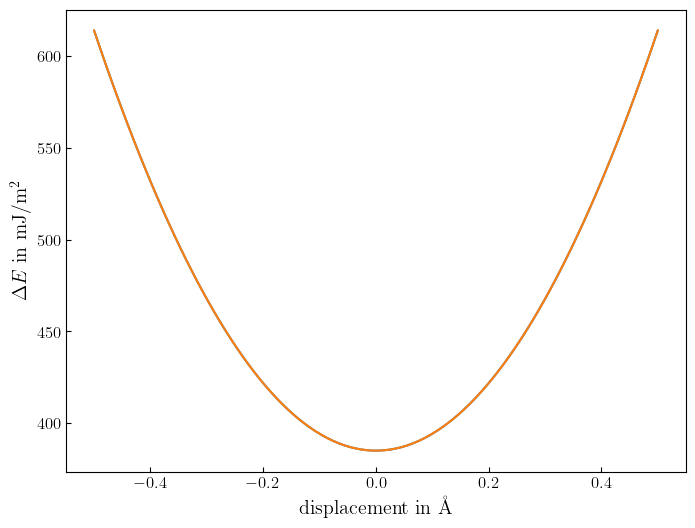

In [16]:
plt.plot(shifts*1e10, energies[:, 0]*1e3)
plt.plot(shifts*1e10, energies[:, 1]*1e3)

#plt.plot(-1*shifts[::1], -energies)
plt.ylabel('$\Delta E$ in mJ/m$^2$')
plt.xlabel('displacement in Å')
plt.show()

## Angular dependence:

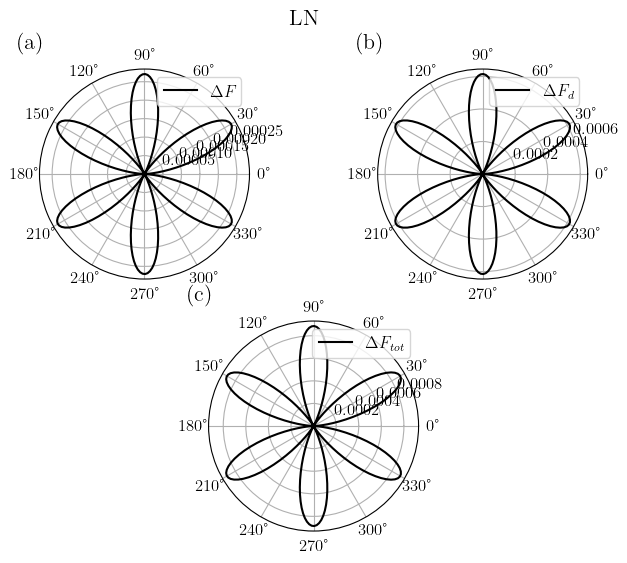

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


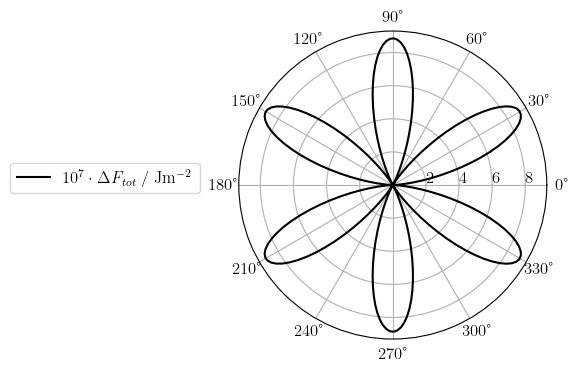

In [17]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(8, 6))
fig, axes = plt.subplot_mosaic("AB;CC", subplot_kw={'projection': 'polar'}, figsize=(8, 6))

#ax.plot(ths, np.linalg.norm( p_inplane, axis=1 ))
ths = np.linspace(0, 2*np.pi, 250)
ens = np.zeros_like(ths)
ens_d = np.zeros_like(ths)

#g1=1e-11
g1 = 4 * 1e-11 
num_intp = 20

# why not interate over 1 unit cell?
for (i,t) in enumerate(ths):
    S1, S2, Xi, Phi = coefs(t, Epsilon11, Epsilon33, Q, C, Ph, return_all=False)
    xL = 2*np.sqrt(g1/S1)

    xs_intp = np.linspace(-0.5*xL, 0.5*xL, num_intp, endpoint=True)

    dx = xs_intp[1] - xs_intp[0]
    dummy = np.zeros(2)
    for x_int in xs_intp:
        dummy += ( free_energy(x_int, t, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=False)  )

    ens[i], ens_d[i] = (dummy  * dx)*1e3 # mJ/m^2

#print(free_energy(0, t, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True)*(xs_intp[-1]-xs_intp[0]))
#print(ens-ens[0])
ens -= ens[0]
#ens = ens/(4*xL)
#ens_d -= ens_d[0]
#ens_d = ens_d/(4*xL)

axes['A'].plot(ths, ens, label='$\Delta F$', color='black')
#axes['A'].set_rmin(np.min(ens))
#axes['A'].set_rmax(np.max(ens))

axes['B'].plot(ths, ens_d, label='$\Delta F_d$', color='black')


axes['C'].plot(ths, (ens+ens_d), label='$\Delta F_{tot}$', color='black')
#axes['C'].set_rmin(av_tot-2e-4)
#axes['C'].set_rmax(av_tot+2e-4)


#ax.set_rmax(5.25e-5)
#ax.set_rmin(4e-5)
for (n, ax) in enumerate(axes):
    axes[ax].set_xticks(np.pi/6*np.arange(12))
    axes[ax].legend(loc='upper right')  
    axes[ax].text(-0.1, 1.1, '('+string.ascii_lowercase[n]+')', transform=axes[ax].transAxes, 
            size=16, weight='bold')

plt.suptitle(f'{crystal}', fontsize=16)
#plt.savefig(f'../tex/images/{crystal}_angular_energy.eps', bbox_inches='tight')
plt.show()

"""in case we only want the last plot"""

# only show the last plot:
fig, ax = plt.subplots(1, subplot_kw={'projection': 'polar'}, figsize=(6, 4))
ax.plot(ths, (ens+ens_d)*1e4, label='$10^{7} \\cdot \\Delta F_{tot}$ / Jm$^{-2}$', color='black')
ax.set_xticks(np.pi/6*np.arange(12))
ax.set_rlabel_position(0)
ax.legend(bbox_to_anchor=(-0.1, 0.6))  
plt.savefig(f'../tex/images/{crystal}_angular_energy_tot.eps', bbox_inches='tight')
plt.show()

## Order paramters LN:

In [18]:
p=Ph-0.11#0.4
ths, de_n, e_5, e_6 = get_strains(p)
ths, pn, pt = inplane_polarization(p)

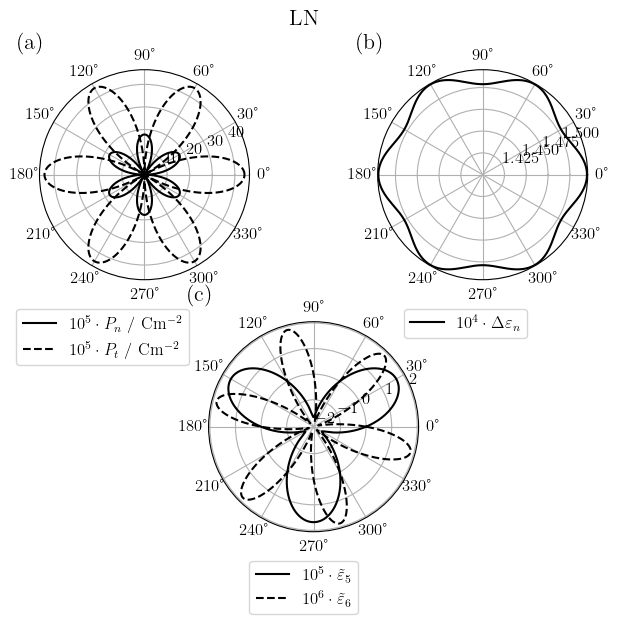

In [19]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(8, 3))
fig, axes = plt.subplot_mosaic("AB;CC", subplot_kw={'projection': 'polar'}, figsize=(8, 6))


axes['A'].plot(ths, 1e5*np.abs(pn), label='$10^5 \\cdot P_n$ / Cm$^{-2}$ ', color='black')
axes['A'].plot(ths, 1e5*np.abs(pt), label='$10^5 \\cdot P_t$ / Cm$^{-2}$ ', color='black', linestyle='--')
#axes['A'].set_rmin(-1)

axes['B'].plot(ths, 1e4*de_n, label='$10^4 \\cdot \\Delta \\varepsilon _n$', color='black')
axes['B'].set_rmin(1.4)

axes['C'].plot(ths, 1e5*e_5, label='$10^5 \\cdot \\tilde{\\varepsilon} _5$', color='black')
axes['C'].plot(ths, 1e6*e_6, label='$10^6 \\cdot \\tilde{\\varepsilon} _6$', color='black', linestyle='--')

for (n, ax) in enumerate(axes):
    axes[ax].set_xticks(np.pi/6*np.arange(12))
    axes[ax].legend(bbox_to_anchor=(0.75, -0.1))#loc='upper right')  
    axes[ax].text(-0.1, 1.1, '('+string.ascii_lowercase[n]+')', transform=axes[ax].transAxes, 
            size=16, weight='bold')

plt.suptitle(f'{crystal}', fontsize=16)
#plt.savefig(f'../tex/images/{crystal}_angular_second.eps', bbox_inches='tight')
plt.show()

In [20]:
p_list = np.linspace(-0.7, 0.7, 50)
inplane_ywall = np.zeros( (len(p_list), 2) )
inplane_xIwall = np.zeros( (len(p_list), 2) )
inplane_xIIwall = np.zeros( (len(p_list), 2) )

for (i, pol) in enumerate(p_list):
    ths, pn, pt = inplane_polarization(pol, nump=13)
    inplane_ywall[i] = [pn[0], pt[0]]
    inplane_xIwall[i] = [pn[3], pt[3]] # rougly at pi/4
    inplane_xIIwall[i] = [pn[9], pt[9]] # rougly at pi/4

In [21]:
ths

array([0.        , 0.52359878, 1.04719755, 1.57079633, 2.0943951 ,
       2.61799388, 3.14159265, 3.66519143, 4.1887902 , 4.71238898,
       5.23598776, 5.75958653, 6.28318531])

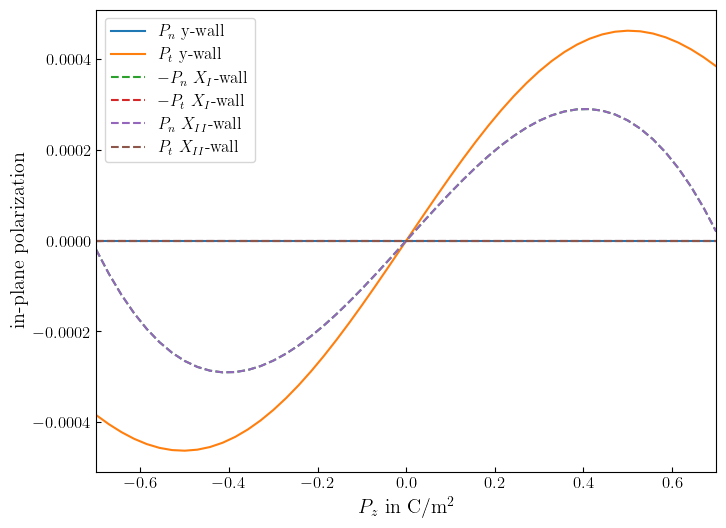

In [22]:
plt.plot(p_list, inplane_ywall[:, 0], label='$P_n$ y-wall')
plt.plot(p_list, inplane_ywall[:, 1], label='$P_t$ y-wall')

plt.plot(p_list, -inplane_xIwall[:, 0], label='$-P_n$ $X_I$-wall', linestyle='dashed')
plt.plot(p_list, -inplane_xIwall[:, 1], label='$-P_t$ $X_I$-wall', linestyle='dashed')
plt.plot(p_list, inplane_xIIwall[:, 0], label='$P_n$ $X_{II}$-wall', linestyle='dashed')
plt.plot(p_list, inplane_xIIwall[:, 1], label='$P_t$ $X_{II}$-wall', linestyle='dashed')

plt.legend()
plt.xlim(-0.7, 0.7)
plt.xlabel('$P_z$ in C/m$^2$')
plt.ylabel('in-plane polarization')
plt.show()

In [23]:
rad = np.linspace(-4, 4, 100)
azm = np.linspace(0, 2 * np.pi, 200)
r, th = np.meshgrid(rad, azm)

pz_dummys = (Ph+0.00) * np.tanh(rad)

den = np.zeros_like(r)
e5 = np.zeros_like(r)
e6 = np.zeros_like(r)

pz = np.zeros_like(r)
pn = np.zeros_like(r)
pt = np.zeros_like(r)

for (it, dist) in enumerate(rad):
    den[:,it], e5[:,it], e6[:,it]  = get_strains(pz_dummys[it], nump=len(azm))[1:]
    pn[:,it], pt[:,it]  = inplane_polarization(pz_dummys[it], nump=len(azm))[1:]

pz = np.meshgrid( pz_dummys, np.ones_like(azm) )[0]

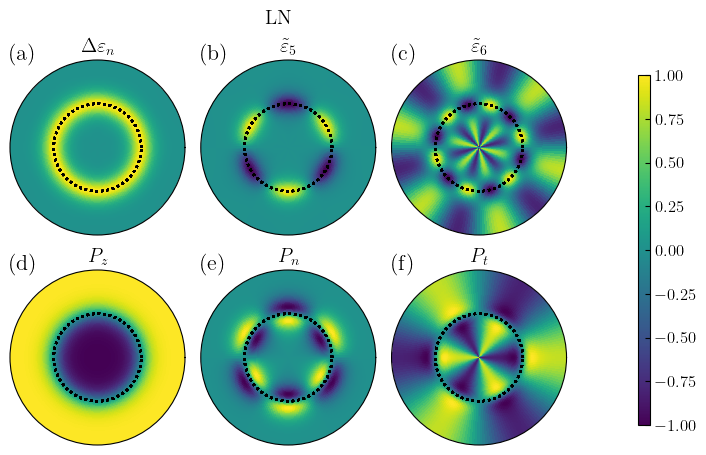

In [24]:
fig = plt.figure(figsize=(8, 5))
#ax = Axes3D(fig)

rows=2
cols=3

ax1 = fig.add_subplot(rows,cols,1, projection="polar")
pcm1 = ax1.pcolormesh(th, r, den/np.max(den), vmin=-1, vmax=1)
ax1.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm1, ax=ax1)

ax2 = fig.add_subplot(rows,cols,2, projection="polar")
pcm2 = ax2.pcolormesh(th, r, e5/np.max(e5), vmin=-1, vmax=1)
ax2.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm2, ax=ax2)

ax3 = fig.add_subplot(rows,cols,3, projection="polar")
pcm3 = ax3.pcolormesh(th, r[:], e6[:, :]/np.max(np.abs(e6)), vmin=-1, vmax=1)
ax3.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm3, ax=ax3)

ax4 = fig.add_subplot(rows,cols,4, projection="polar")
pcm4 = ax4.pcolormesh(th, r, pz/np.max(pz), vmin=-1, vmax=1)
ax4.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm1, ax=ax1)

ax5 = fig.add_subplot(rows,cols,5, projection="polar")
pcm5 = ax5.pcolormesh(th, r, pn/np.max(pn), vmin=-1, vmax=1)
ax5.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm2, ax=ax2)

ax6 = fig.add_subplot(rows,cols,6, projection="polar")
pcm6 = ax6.pcolormesh(th, r, pt/np.max(np.max(pt)), vmin=-1, vmax=1)
ax6.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm6)


titles = ['$\\Delta \\varepsilon_n$', '$\\tilde{\\varepsilon}_5$', '$\\tilde{\\varepsilon}_6$', '$P_z$', '$P_n$', '$P_t$']
for (it, ax) in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
    ax.grid()
    ax.set_xticks([])
    ax.set_rticks([])
    ax.set_title(titles[it])
    ax.text(-0, 1.0, '('+string.ascii_lowercase[it]+')', transform=ax.transAxes, 
            size=16, weight='bold')

fig.subplots_adjust(right=0.95, wspace=-0.2, hspace=0.2)
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
fig.colorbar(pcm6, cax=cbar_ax)

plt.suptitle(f'{crystal}')

#plt.savefig(f'../tex/images/{crystal}_polar_heatmap.png')
plt.show()

# For LT:

In [34]:
# Coefficients for LT:
crystal = 'LT'

"""
#values from GLD paper:
Ph = 50 * 1e-2
Epsilon11 = 52.7
Epsilon33 = 44.0
C = 1e11 * np.array([
    #[2.3305, 0.4644, 0.8358, -1.067],
    [2.3305, 0.4644, 0.8358, -0.12],
    [0, 0, 0, 0],
    [0, 0, -2.7414, 0], 
    #[0, 0, 2.84, 0], 
    [0, 0, 0, 0.9526]
])
# Qs from GLD table
Q =np.array([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [-0.00485, 0, 0.016, 0], 
    [0, 0.016, 0, 0.056]
    #[0, 0.021, 0, 0.056]
])

# original Qs
Q =np.array([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [-0.005, 0, 0.021, 0], 
    [0, 0.016, 0, 0.059]
])



#values from DFT:
Ph = 50 * 1e-2 #?
Epsilon11 = 52.7 #?
Epsilon33 = 44.0 #?
C = 1e11 * np.array([
    [2.3010, 0.5087, 0.8177, -0.0764],
    [0, 0, 0, 0],
    [0, 0, 2.7168, 0], 
    [0, 0, 0, 0.9154]
])
Q =np.array([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [-0.00485, 0, 0.016, 0], 
    [0, 0.016, 0, 0.056]
    #[0, 0.021, 0, 0.056]
])
"""

#from yamada:
Ph = 50 * 1e-2 #?
Epsilon11 = 51.0 #?
Epsilon33 = 45.0 #?
C = 1e11 * np.array([
    [2.39, 0.41, 0.80, -0.22],
    [0, 0, 0, 0],
    [0, 0, 2.84, 0], 
    [0, 0, 0, 1.13]
])
Q =np.array([
    [0, 0, 0, 0], 
    [0, 0, 0, 0],
    [-0.005, 0, 0.021, 0], 
    [0, 0.016, 0, 0.059]
])

S1, S2, Xi, Phi, a, b, g, l = coefs(np.pi/2, Epsilon11, Epsilon33, Q, C, Ph, print_pars=True, return_all=True)
for p in (a, b, g, l):
    print([f"{c:.2e}" for c in p])

 1.255E+09
 5.081E+09
 2.215E+09
 1.420E+11
 7.000E+10
 4.950E+10
 8.000E+10
 5.650E+10
-2.200E+10
 1.400E+08
 2.782E+09
-4.180E+09
 6.667E+09
 6.850E-04
-2.835E-03
['1.25e+09', '5.08e+09', '2.21e+09']
['1.42e+11', '7.00e+10', '4.95e+10', '8.00e+10', '5.65e+10', '-2.20e+10']
['1.40e+08', '2.78e+09', '-4.18e+09', '6.67e+09']
['6.85e-04', '-2.83e-03']


In [23]:
xl_X = 1.76*1e-10
xl_Y = 1.67*1e-10
print(f'Value for g1 : {S1/2 * (xl_X)**2 :.2E} (obtained from fit of profile)')
print(f'Value for g1 : {S1/2 * (xl_Y)**2 :.2E} (obtained from fit of profile)')

Value for g1 : 1.97E-11 (obtained from fit of profile)
Value for g1 : 1.77E-11 (obtained from fit of profile)


In [24]:
print(f'X-wall motion: {activation_energy(a[0], Ph, xl_X, 5.19*1e-10)*1e3:.1f} mJ/m^2')
print(f'Y-wall motion: {activation_energy(a[0], Ph, xl_Y, 5.19*1e-10)*1e3:.1f} mJ/m^2')

X-wall motion: 48.8 mJ/m^2
Y-wall motion: 47.0 mJ/m^2


In [25]:
a[0]*1e-9

1.254898963747799

In [26]:
np.sqrt(S1/S2)

0.4999999512263203

## Energies LT:

In [27]:
g1 = 2.5 * 1e-11 
#theta = 0
#S1, S2, Xi, Phi = coefs(theta, Epsilon11, Epsilon33, Q, C, Ph, return_all=False)
xL = 2*np.sqrt(g1/S1)

num_intp = 1000
xs_intp = np.linspace(-2*xL, 2*xL, num_intp, endpoint=True)
dx = xs_intp[1] - xs_intp[0]

# y walls:
theta = 0
dummy = 0
for x_int in xs_intp:
        dummy += free_energy(x_int, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph])#[0]  

energy = np.sum( dummy ) * dx
energy_hom = np.sum( free_energy(0, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True) ) * (xs_intp[-1] - xs_intp[0])
form_eny = energy - energy_hom

# x walls:
theta = np.pi/6
dummy = 0
for x_int in xs_intp:
        dummy += free_energy(x_int, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph])#[0]  

energy = np.sum( dummy ) * dx
energy_hom = np.sum( free_energy(0, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True) ) * (xs_intp[-1] - xs_intp[0])
form_enx = energy - energy_hom

print(f'E_x = {form_enx} J/m^2\nE_y = {form_eny} J/m^2')
print(f'E_x-E_y = {(form_enx - form_eny)/(1)}')


E_x = 0.059276966116817965 J/m^2
E_y = 0.059276699018402115 J/m^2
E_x-E_y = 2.6709841585009775e-07


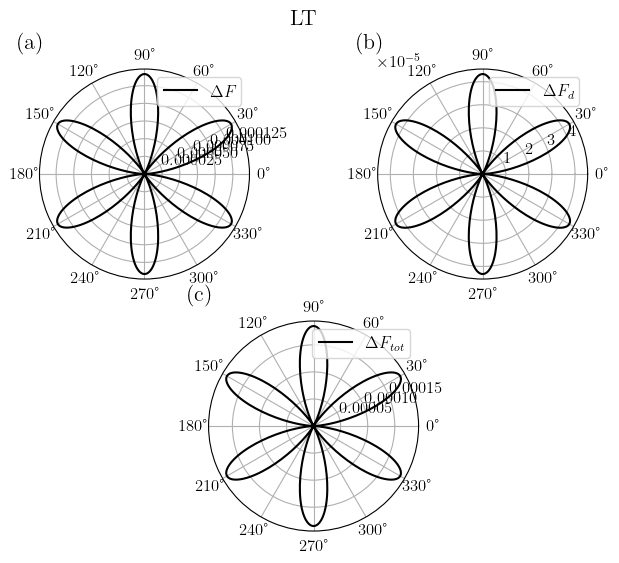

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


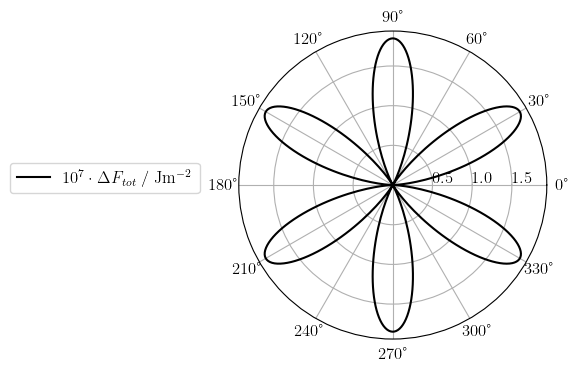

In [35]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(8, 6))
fig, axes = plt.subplot_mosaic("AB;CC", subplot_kw={'projection': 'polar'}, figsize=(8, 6))

#ax.plot(ths, np.linalg.norm( p_inplane, axis=1 ))
ths = np.linspace(0, 2*np.pi, 500)
ens = np.zeros_like(ths)
ens_d = np.zeros_like(ths)

#g1=1e-11
g1 = 2.5 * 1e-11
num_intp = 10

# why not interate over 1 unit cell?
for (i,t) in enumerate(ths):
    S1, S2, Xi, Phi = coefs(t, Epsilon11, Epsilon33, Q, C, Ph, return_all=False)
    xL = 2*np.sqrt(g1/S1)
    xs_intp = np.linspace(-4*xL, 4*xL, num_intp, endpoint=True)
    dx = xs_intp[1] - xs_intp[0]
    dummy = np.zeros(2)
    for x_int in xs_intp:
        dummy += ( free_energy(x_int, t, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=False)  )

    #ens[i], ens_d[i] = (dummy  * dx)#/( xs_intp[-1] - xs_intp[0] ) #- free_energy(0, t, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True)*(xs_intp[-1]-xs_intp[0])  #* 1e3 # this should be energy in J/m^2
    ens[i], ens_d[i] = (dummy  * dx) * 1e3 #- free_energy(0, t, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True)*(xs_intp[-1]-xs_intp[0])  * 1e3 # this should be energy in mJ/m^2
#energy_hom = np.sum( free_energy(0, theta, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True) ) * (xs_intp[-1] - xs_intp[0])

#print(free_energy(0, t, g1, [Epsilon11, Epsilon33, Q, C, Ph], homo=True)*(xs_intp[-1]-xs_intp[0]))
#print(ens-ens[0])
ens -= ens[0]
ens_d -= ens_d[0]

axes['A'].plot(ths, ens, label='$\Delta F$', color='black')
#axes['A'].set_rmin(np.min(ens))
#axes['A'].set_rmax(np.max(ens))

axes['B'].plot(ths, ens_d, label='$\Delta F_d$', color='black')


axes['C'].plot(ths, (ens+ens_d), label='$\Delta F_{tot}$', color='black')
#axes['C'].set_rmin(av_tot-2e-4)
#axes['C'].set_rmax(av_tot+2e-4)


#ax.set_rmax(5.25e-5)
#ax.set_rmin(4e-5)
for (n, ax) in enumerate(axes):
    axes[ax].set_xticks(np.pi/6*np.arange(12))
    axes[ax].legend(loc='upper right')  
    axes[ax].text(-0.1, 1.1, '('+string.ascii_lowercase[n]+')', transform=axes[ax].transAxes, 
            size=16, weight='bold')

plt.suptitle(f'{crystal}', fontsize=16)
#plt.savefig(f'../tex/images/{crystal}_angular_energy.eps', bbox_inches='tight')
plt.show()

"""in case we only want the last plot"""

# only show the last plot:
fig, ax = plt.subplots(1, subplot_kw={'projection': 'polar'}, figsize=(6, 4))
ax.plot(ths, (ens+ens_d)*1e4, label='$10^{7} \\cdot \Delta F_{tot}$ / Jm$^{-2}$', color='black')
ax.set_xticks(np.pi/6*np.arange(12))
ax.set_yticks([0.5, 1.0, 1.5])
ax.set_rlabel_position(0)
#ax.legend(loc='lower center')  
ax.legend(bbox_to_anchor=(-0.1, 0.6))  
plt.savefig(f'../tex/images/{crystal}_angular_energy_tot.eps', bbox_inches='tight')
plt.show()

## Order paramters LT:

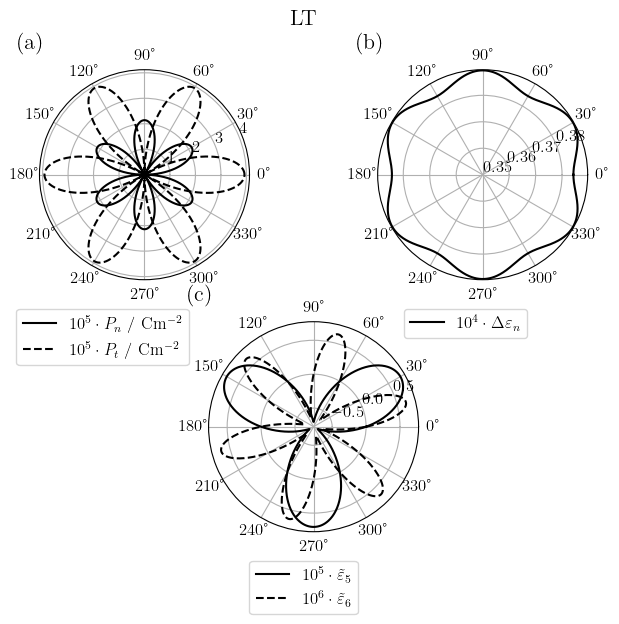

In [22]:
fig, axes = plt.subplot_mosaic("AB;CC", subplot_kw={'projection': 'polar'}, figsize=(8, 6))

pol_val = 0.43
ths, de_n, e_5, e_6 = get_strains(pol_val)
ths, pn, pt = inplane_polarization(pol_val)

axes['A'].plot(ths, 1e5*np.abs(pn), label='$10^5 \\cdot P_n$ / Cm$^{-2}$ ', color='black')
axes['A'].plot(ths, 1e5*np.abs(pt), label='$10^5 \\cdot P_t$ / Cm$^{-2}$ ', color='black', linestyle='--')

axes['B'].plot(ths, 1e4*de_n, label='$10^4 \\cdot \\Delta \\varepsilon _n$', color='black')
axes['B'].set_rmin(0.35)

axes['C'].plot(ths, 1e5*e_5, label='$10^5 \\cdot \\tilde{\\varepsilon} _5$', color='black')
axes['C'].plot(ths, 1e6*e_6, label='$10^6 \\cdot \\tilde{\\varepsilon} _6$', color='black', linestyle='--')

for (n, ax) in enumerate(axes):
    axes[ax].set_xticks(np.pi/6*np.arange(12))
    axes[ax].legend(bbox_to_anchor=(0.75, -0.1))  
    axes[ax].text(-0.1, 1.1, '('+string.ascii_lowercase[n]+')', transform=axes[ax].transAxes, 
            size=16, weight='bold')

plt.suptitle(f'{crystal}', fontsize=16)
#plt.savefig(f'../tex/images/{crystal}_angular_second.eps', bbox_inches='tight')
plt.show()

In [23]:
rad = np.linspace(-4, 4, 100)
azm = np.linspace(0, 2 * np.pi, 200)
r, th = np.meshgrid(rad, azm)

pz_dummys = Ph * np.tanh(rad)

den = np.zeros_like(r)
e5 = np.zeros_like(r)
e6 = np.zeros_like(r)

pz = np.zeros_like(r)
pn = np.zeros_like(r)
pt = np.zeros_like(r)

for (it, dist) in enumerate(rad):
    den[:,it], e5[:,it], e6[:,it]  = get_strains(pz_dummys[it], nump=len(azm))[1:]
    pn[:,it], pt[:,it]  = inplane_polarization(pz_dummys[it], nump=len(azm))[1:]

pz = np.meshgrid( pz_dummys, np.ones_like(azm) )[0]

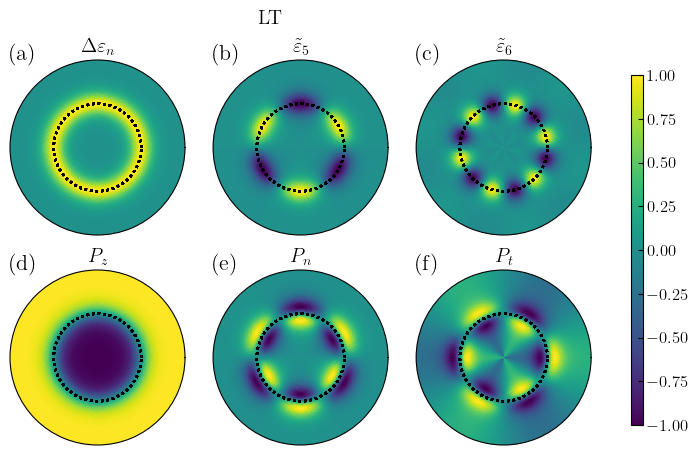

In [24]:
fig = plt.figure(figsize=(8, 5))
#ax = Axes3D(fig)

rows=2
cols=3

ax1 = fig.add_subplot(rows,cols,1, projection="polar")
pcm1 = ax1.pcolormesh(th, r, den/np.max(np.abs(den)), vmin=-1, vmax=1)
ax1.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm1, ax=ax1)

ax2 = fig.add_subplot(rows,cols,2, projection="polar")
pcm2 = ax2.pcolormesh(th, r, e5/np.max(np.abs(e5)), vmin=-1, vmax=1)
ax2.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm2, ax=ax2)

ax3 = fig.add_subplot(rows,cols,3, projection="polar")
pcm3 = ax3.pcolormesh(th, r, e6/np.max(np.abs(e6)), vmin=-1, vmax=1)
ax3.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm3, ax=ax3)

ax4 = fig.add_subplot(rows,cols,4, projection="polar")
pcm4 = ax4.pcolormesh(th, r, pz/np.max(pz), vmin=-1, vmax=1)
ax4.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm1, ax=ax1)

ax5 = fig.add_subplot(rows,cols,5, projection="polar")
pcm5 = ax5.pcolormesh(th, r, pn/np.max(pn), vmin=-1, vmax=1)
ax5.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm2, ax=ax2)

ax6 = fig.add_subplot(rows,cols,6, projection="polar")
pcm6 = ax6.pcolormesh(th, r, pt/np.max(pt), vmin=-1, vmax=1)
ax6.plot(th, np.zeros_like(th), "k", linestyle='dotted')
#fig.colorbar(pcm6)


titles = ['$\\Delta \\varepsilon_n$', '$\\tilde{\\varepsilon}_5$', '$\\tilde{\\varepsilon}_6$', '$P_z$', '$P_n$', '$P_t$']
for (it, ax) in enumerate((ax1, ax2, ax3, ax4, ax5, ax6)):
    ax.grid()
    ax.set_xticks([])
    ax.set_rticks([])
    ax.set_title(titles[it])
    ax.text(-0, 1.0, '('+string.ascii_lowercase[it]+')', transform=ax.transAxes, 
            size=16, weight='bold')

fig.subplots_adjust(right=0.95, wspace=-0.2, hspace=0.2)
cbar_ax = fig.add_axes([0.95, 0.15, 0.015, 0.7])
fig.colorbar(pcm6, cax=cbar_ax)

plt.suptitle(f'{crystal}')

#plt.savefig(f'../tex/images/{crystal}_polar_heatmap.png')
plt.show()

# quiver plot of in-plane polarization

In [85]:
thetas, x_normals = np.meshgrid( np.linspace(0, 2*np.pi, endpoint=False, num=60), np.linspace(0, 2, 30)[5:] )
U_pol = np.ones_like( x_normals )
V_pol = np.ones_like( x_normals )

In [86]:
for (i,angle) in enumerate(thetas[0]):
    _, _, Xi_, Phi_ = coefs(angle, Epsilon11, Epsilon33, Q, C, Ph)
    for (j,radius) in enumerate(x_normals[:, 0]):
        pz = Ph * np.tanh(5*(radius - 1))
        #pz = 2* Ph * (np.heaviside((radius - 1), 0) - 0.5 )
        pn, pt = np.dot( Xi_, np.array([pz, pz**3, pz**5]) )[0:2]
        p_norm = np.sqrt(pn**2 + pt**2)
        U_pol[j, i] = (np.cos(angle)*pn - np.sin(angle)*pt)#/p_norm
        V_pol[j, i] = (np.sin(angle)*pn + np.cos(angle)*pt)#/p_norm 



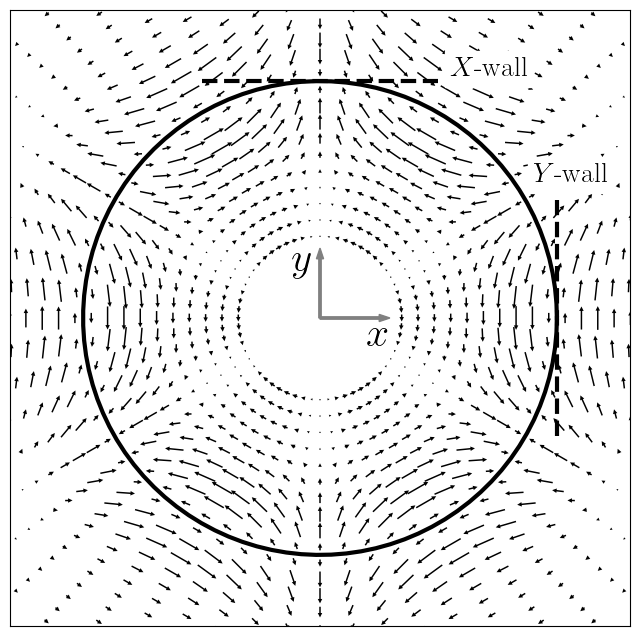

In [88]:
plt.figure(figsize=(8, 8))
plt.plot(1.0*np.cos(np.linspace(0, 2*np.pi, 100)), 1.0*np.sin(np.linspace(0, 2*np.pi, 100)), 'k', label='Circle', zorder=0, linewidth=3)


plt.quiver(x_normals*np.cos(thetas), x_normals*np.sin(thetas), U_pol, V_pol, zorder=1, pivot='mid', headaxislength=3, headlength=3, headwidth=3, color='k')
# Define the hexagon's vertices (x, y) coordinates
"""
vertices_in = np.array([[1, 0], [np.cos(np.pi/3), np.sin(np.pi/3)], [-np.cos(np.pi/3), np.sin(np.pi/3)],
                     [-1, 0], [-np.cos(np.pi/3), -np.sin(np.pi/3)], [np.cos(np.pi/3), -np.sin(np.pi/3)], [1, 0]])
vertices_out = 1/np.cos(np.pi/6) * vertices_in
"""
# Plot the hexagon using a scatter plot
#plt.scatter(vertices[:, 0], vertices[:, 1], c='blue', marker='o', s=100)

# plot coordinate system
plt.annotate('$y$', xy=(-0.12, 0.2), size=30, weight='bold', color='k')
plt.annotate('$x$', xy=(0.2, -0.12), size=30, weight='bold', color='k')
plt.arrow(0, 0, 0, 0.25, width=0.01, color='gray')
plt.arrow(0, 0, 0.25, 0.0, width=0.01, color='gray')

"""
# +x directions:
plt.text(-0.8,-0.95, '$+x$', size=20, verticalalignment='bottom', horizontalalignment='left', backgroundcolor='white')
plt.arrow(-1.0, -1.0, 0.25, 0.0, width=0.01, color='gray')
plt.arrow(-1.0, -1.0, 0.25*np.cos(2*np.pi/3), 0.25*np.sin(2*np.pi/3), width=0.01, color='gray')
plt.arrow(-1.0, -1.0, 0.25*np.cos(4*np.pi/3), 0.25*np.sin(4*np.pi/3), width=0.01, color='gray')
# +y directions:
plt.text(1.05, -0.7, '$+y$', size=20, verticalalignment='center', horizontalalignment='left', backgroundcolor='white')
plt.arrow(1.0, -1.0, 0.0, 0.25, width=0.01, color='gray')
plt.arrow(1.0, -1.0, 0.25*np.cos(7*np.pi/6), 0.25*np.sin(7*np.pi/6), width=0.01, color='gray')
plt.arrow(1.0, -1.0, 0.25*np.cos(11*np.pi/6), 0.25*np.sin(11*np.pi/6), width=0.01, color='gray')
"""
# annotate wall types
plt.hlines(1, -0.5, 0.5, linewidth=3, color='k', linestyle='dashed')
plt.text(0.55, 1, '$X$-wall', size=20, weight='bold', verticalalignment='bottom', horizontalalignment='left', backgroundcolor='white')
plt.vlines(1, -0.5, 0.5, linewidth=3, color='k', linestyle='dashed')
plt.text(0.9, 0.55, '$Y$-wall', size=20, weight='bold', verticalalignment='bottom', horizontalalignment='left', backgroundcolor='white')



plt.axis('equal')
plt.xticks([])
plt.yticks([])
plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)
#plt.savefig(f'../tex/images/{crystal}_inplane_vector.png', bbox_inches='tight')
plt.savefig(f'../tex/images/{crystal}_inplane_vector.eps', bbox_inches='tight')
plt.show()

# Polarization normal and transverse to wall (LN)


In [102]:
data = np.loadtxt('../data/LN/pol_4y.dat')
x_ns = data[:, 0]

p1 = data[:, 1:4]/100 # Li contributions
p2 = data[:, 4:]/100  # Nb contributions

p1z = p1[:, 2]
p2z = p2[:, 2]

# perfrom snfit
ptot = p1z + p2z
x_ns_tot = np.linspace(x_ns[0], x_ns[-1], 1000, endpoint=True)
pars = curve_fit(snfit, x_ns, ptot, bounds=([0.6, -0.6, 0.9], [0.8, 0, 1]))[0]
print(pars)

[ 0.6160667  -0.6         0.99972689]


In [103]:
S1, S2, Xi, Phi, a, b, g, l = coefs(np.pi/4, Epsilon11, Epsilon33, Q, C, Ph, print_pars=False, return_all=True)

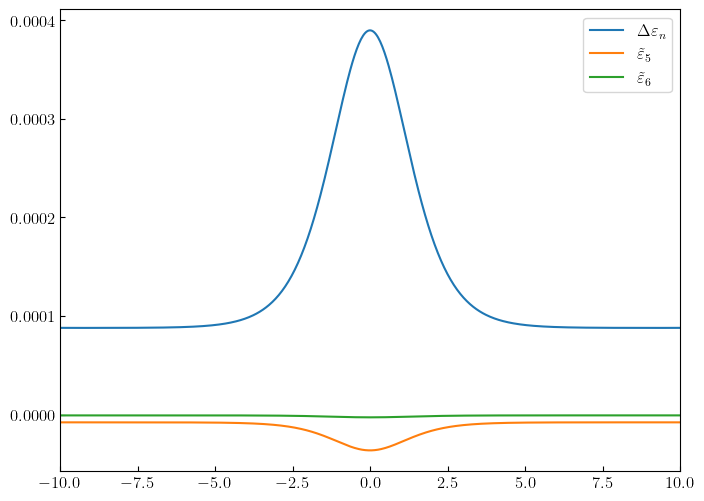

In [104]:
strains = []
for xn in x_ns_tot:
    strains.append(strains_all(xn, Phi, pars))

strains = np.array(strains)
"""
plt.plot(x_ns_tot, strains[:, 0]/np.max(strains[:, 0]), label='$\\Delta \\varepsilon_n$') 
plt.plot(x_ns_tot, strains[:, 1]/np.max(strains[:, 0]), label='$\\tilde{\\varepsilon}_5$')
plt.plot(x_ns_tot, strains[:, 2]/np.max(strains[:, 0]), label='$\\tilde{\\varepsilon}_6$')
"""
plt.plot(x_ns_tot, strains[:, 0], label='$\\Delta \\varepsilon_n$') 
plt.plot(x_ns_tot, strains[:, 1], label='$\\tilde{\\varepsilon}_5$')
plt.plot(x_ns_tot, strains[:, 2], label='$\\tilde{\\varepsilon}_6$')

plt.xlim([-10, 10])
plt.legend()
plt.show()

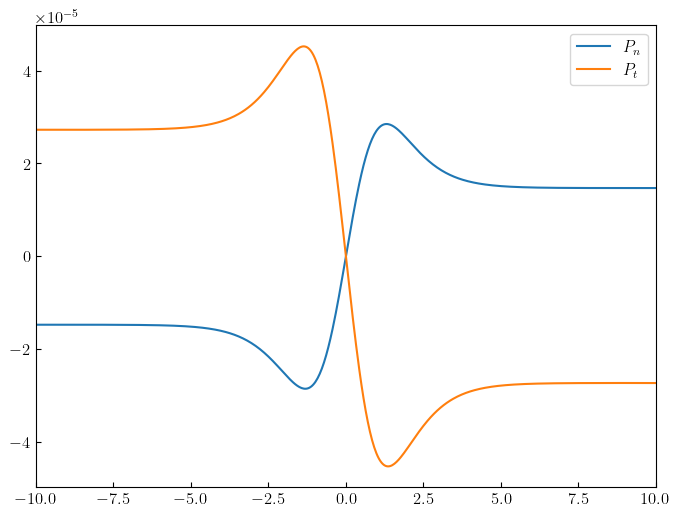

In [105]:
polarizations = []
for xn in x_ns_tot:
    polarizations.append(pol_all(xn, Xi, pars))

polarizations = np.array(polarizations)

#plt.plot(x_ns_tot, polarizations[:, 0]/max(polarizations[:, 0]), label='$P_n$') 
#plt.plot(x_ns_tot, polarizations[:, 1]/max(polarizations[:, 1]), label='$P_t$') 

plt.plot(x_ns_tot, polarizations[:, 0], label='$P_n$') 
plt.plot(x_ns_tot, polarizations[:, 1], label='$P_t$') 


plt.xlim([-10, 10])
plt.legend()
plt.show()

# Plot from measurement:

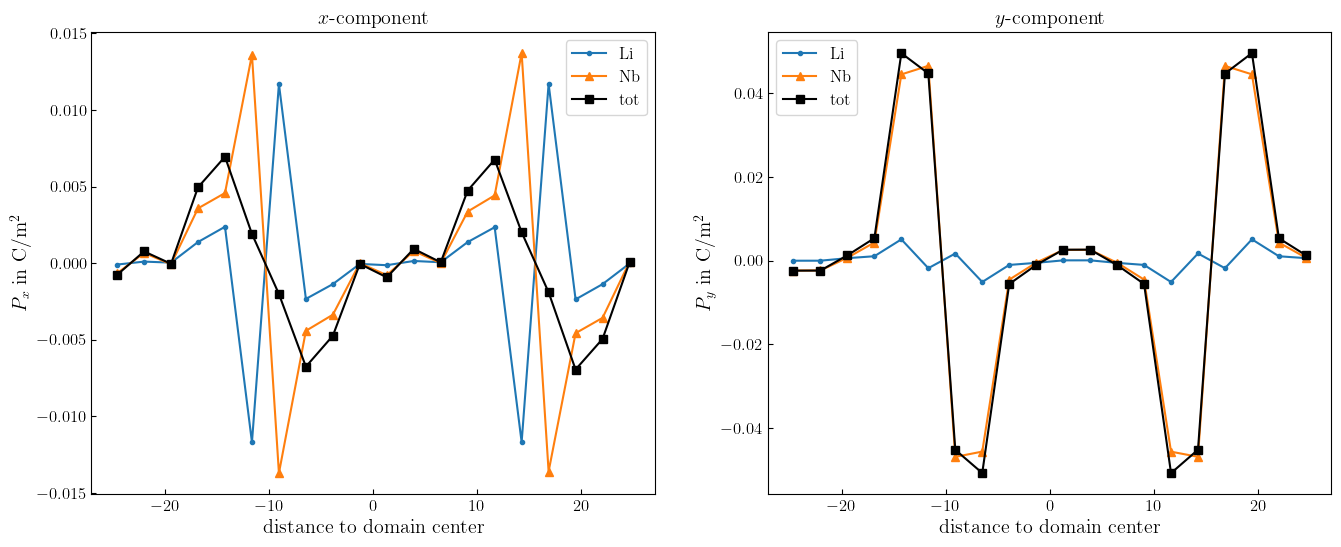

In [30]:
shift = 6

p1x = np.roll(p1[:, 0], shift)
p2x = np.roll(p2[:, 0], shift)

p1y = np.roll(p1[:, 1], shift)
p2y = np.roll(p2[:, 1], shift)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(x_ns, p1x, marker='.', label='Li')
ax1.plot(x_ns, p2x, marker='^', label='Nb')
ax1.plot(x_ns, p1x+p2x, marker='s', label='tot', color='k')



#ax1.plot(x_ns_tot, 1.5e2*ps[:, 0]) 
ax1.set_title('$x$-component')
ax1.set_ylabel('$P_x$ in C/m$^2$')
ax1.set_xlabel('distance to domain center')
ax1.legend()
#ax1.set_xlim([-20, 20])

ax2.plot(x_ns, p1y, marker='.', label='Li')#, linestyle='None')
ax2.plot(x_ns, p2y, marker='^', label='Nb')#, linestyle='None')
ax2.plot(x_ns, p1y+p2y, marker='s', label='tot', color='k')#, linestyle='none')
ax2.set_title('$y$-component')
ax2.set_ylabel('$P_y$ in C/m$^2$')
ax2.set_xlabel('distance to domain center')
ax2.legend()
#ax2.set_xlim([-20, 20])




#ax2.plot(x_ns_tot, 1e5*ps[:, 1]) 
plt.show()